In [1]:
import pandas as pd
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Preprocessing the Data

In [4]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [6]:
def process_df(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    cols = ["Age_categories","Fare_categories","Title","Cabin_type","Sex"]
    for c in cols:
        df = create_dummies(df,c)
        
    return df

train = process_df(train)
holdout = process_df(holdout)

## Exploring the Data

In [8]:
train[["SibSp","Parch"]].dtypes

SibSp    int64
Parch    int64
dtype: object

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
# train["SibSp"].plot.hist()
sibsp_pivot = train.pivot_table(index=["SibSp"],values=["Survived"])
sibsp_sur = pd.Series(data=sibsp_pivot["Survived"],index=sibsp_pivot.index)
sibsp_die = 1-sibsp_sur

sibsp_df = pd.DataFrame({"Survived": sibsp_sur, "Died": sibsp_die})
sibsp_df

,Survived,Died
SibSp,,
0,0.345395,0.654605
1,0.535885,0.464115
2,0.464286,0.535714
3,0.250000,0.750000
4,0.166667,0.833333
5,0.000000,1.000000
8,0.000000,1.000000


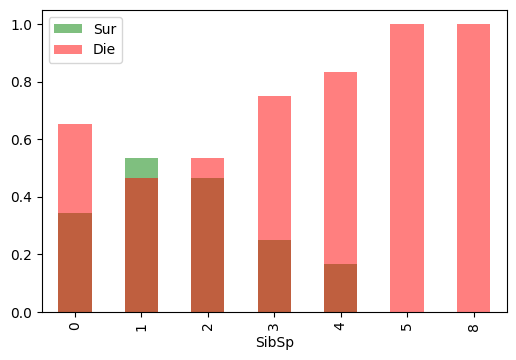

In [46]:
sibsp_df["Survived"].plot.bar(label="Sur",color="green",alpha=0.5)
sibsp_df["Died"].plot.bar(label="Die",color="red",alpha=0.5)
plt.legend()
plt.show()

In [47]:
parch_pivot = train.pivot_table(index=["Parch"],values=["Survived"])
parch_sur = pd.Series(data=sibsp_pivot["Survived"],index=parch_pivot.index)
parch_die = 1-parch_sur

parch_df = pd.DataFrame({"Survived": parch_sur, "Died": parch_die})
parch_df

,Survived,Died
Parch,,
0,0.345395,0.654605
1,0.535885,0.464115
2,0.464286,0.535714
3,0.250000,0.750000
4,0.166667,0.833333
5,0.000000,1.000000
6,NaN,NaN


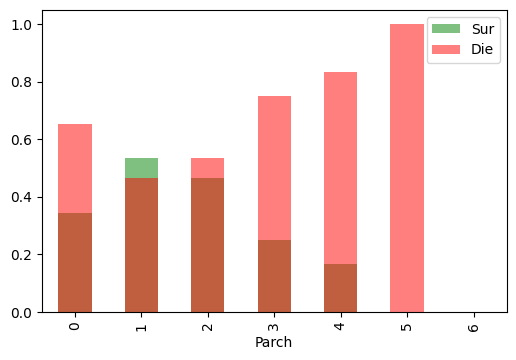

In [48]:
parch_df["Survived"].plot.bar(label="Sur",color="green",alpha=0.5)
parch_df["Died"].plot.bar(label="Die",color="red",alpha=0.5)
plt.legend()
plt.show()

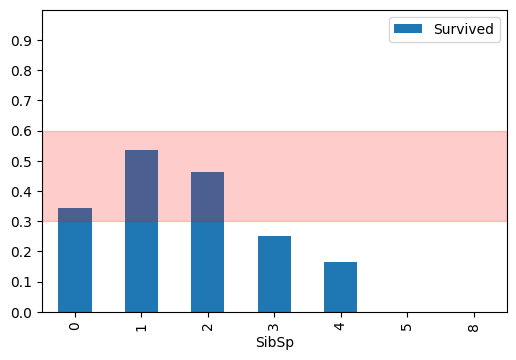

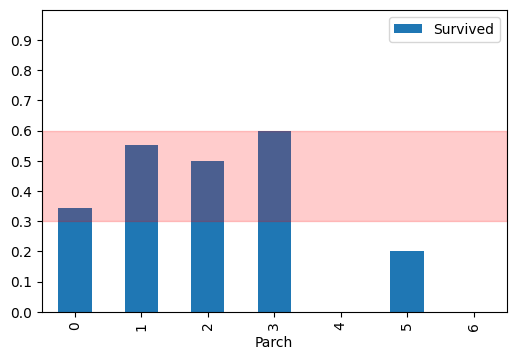

In [49]:
import numpy as np
explore = train[["SibSp","Parch","Survived"]]
for col in explore.columns.drop("Survived"):
    pivot = explore.pivot_table(index=col,values="Survived")
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.axhspan(.3, .6, alpha=0.2, color='red')
    plt.show()

The SibSp column shows the number of siblings and/or spouses each passenger had on board, while the Parch columns shows the number of parents or children each passenger had onboard. Neither column has any missing values.

The distribution of values in both columns is skewed right, with the majority of values being zero.

You can sum these two columns to explore the total number of family members each passenger had onboard. The shape of the distribution of values in this case is similar, however there are less values at zero, and the quantity tapers off less rapidly as the values increase.

Looking at the survival rates of the the combined family members, you can see that few of the over 500 passengers with no family members survived, while greater numbers of passengers with family members survived.

## Engineering New Features

In [58]:
def check_isalone(row):
    if row["SibSp"] + row["Parch"] > 0:
        return 0
    else:
        return 1

def process_family(df):
    df["isalone"] = df.apply(check_isalone,axis=1)
    return df

train = process_family(train)
holdout = process_family(holdout)
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male,isalone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,1,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,0,0,0,0,0,0,1,0,0


## Selecting the Best-Performing Features

In [71]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis=1)
    df = df.dropna(axis=1)
    rf = RandomForestClassifier(random_state=1)
    all_X = df.drop(["PassengerId","Survived"],axis=1)
    all_y = df["Survived"]
    selector = RFECV(rf, cv=10)
    selector.fit(all_X,all_y)
    return all_X.columns[selector.support_]

optimized_columns = select_features(train)
optimized_columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Cabin_type_A', 'Cabin_type_B',
       'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown',
       'Sex_female', 'Sex_male', 'isalone'],
      dtype='object')

## Selecting and Tuning Different Algorithms

In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


def select_model(df, features):
    all_X = df[features]
    all_y = df["Survived"]
    dictionaries = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters": {
                "solver": ["newton-cg", "lbfgs", "liblinear"]
            }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters": {
                "n_neighbors": range(1,20,2),
                "weights": ["distance","uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2]
            }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(),
            "hyperparameters": {
                "n_estimators": [4,6,9],
                "criterion": ["entropy","gini"],
                "max_depth": [2,5,10],
                "max_features": ["log2","sqrt"],
                "min_samples_leaf": [1,5,8],
                "min_samples_split": [2,3,5]
            }
        }
    ]
    for d in dictionaries:
        print(d["name"])
        grid = GridSearchCV(d["estimator"],param_grid=d["hyperparameters"],cv=10)
        grid.fit(all_X,all_y)
        d["best_score"] = grid.best_score_
        d["best_param"] = grid.best_params_
        d["best_estimator"] = grid.best_estimator_
        print(d["best_param"])
        print(d["best_score"])
        print("-----------")
        
    return max(dictionaries, key=lambda x: x["best_score"])["best_estimator"]

best_model = select_model(train, optimized_columns)

LogisticRegression


/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/dataquest/s

{'solver': 'lbfgs'}
0.8204744069912608
-----------
KNeighborsClassifier
{'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.7767041198501874
-----------
RandomForestClassifier
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 9}
0.8462796504369539
-----------


## Making a Submission to Kaggle

In [73]:
def save_submission_file(model,features,filename="submission.csv"):
        holdout_predictions = model.predict(holdout[features])
        submission = pd.DataFrame({
            "PassengerId":holdout["PassengerId"],
            "Survived": holdout_predictions
        })
        submission.to_csv(filename,index=False)
        
save_submission_file(best_model,optimized_columns)